# Project Description and Goals

Zillow is one of the most popular real estate databases online. One of Zillow’s key features is its Zestimates, a popular consumer tool for seeing how much homes are worth.




Zestimates offer users a starting point in home valuation, but these numbers may not be as accurate as one might think for a variety of reasons and there may still be some error.




That is why Zillow's dataset includes the log error information, which is the difference between sales price and estimated price.



### What is driving the errors in Zestimates?

For this project we are working with the Zillow dataset using the 2017 properties and predictions data for single unit / single family homes.

This notebook consists of discoveries made and work that was done related to uncovering what the drivers of the error in the zestimate is.

### Objectives for this project include:
- Identifying the drivers for errors in Zestimates by incorporating clustering methodologies.
- Documenting process and analysis throughout the data science pipeline.
- Demonstrating the information that was discovered.
- Deliverables:
    - README.md file containing overall project information, how to reproduce work, and notes from project planning.
    - Jupyter Notebook Report detailing the pipeline process.
    - Python modules that automate the data acquistion, preparation, and exploration process. 

### Pipeline Process:
1. Acquire
2. Prepare
3. Explore
4. Model/Evaluate
5. Deliver

### Initial hypotheses
- Is log error  significantly different for properties in LA County vs Orange County vs Ventura County?
- Is there a correlation between square footage of a home and log error?
- Is there a relationship between tax value and log error?
- Could there be clusters in square footage and county location that can help predict log error? 

### Project Imports

In [27]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# acquire, prepare, and explore
import wrangle as w
import explore as ex

# statistical testing
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Regression Modeling
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Data Acquisition

In [2]:
df = w.get_zillow_data(cached=True)
df.head()

,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,bathroomcnt,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,NaN,NaN,2.0,NaN,NaN,NaN,10711855,1087254,NaN,2.0,...,NaN,6.037113e+13,-0.007357,2017-07-07,NaN,NaN,NaN,Central,NaN,NaN
1,NaN,NaN,2.0,NaN,NaN,1.0,10711877,1072280,NaN,2.0,...,NaN,6.037113e+13,0.021066,2017-08-29,Central,NaN,NaN,Central,NaN,NaN
2,NaN,NaN,2.0,NaN,NaN,1.0,10711888,1340933,NaN,2.0,...,NaN,6.037113e+13,0.077174,2017-04-04,Central,NaN,NaN,Central,NaN,NaN
3,NaN,NaN,2.0,NaN,NaN,NaN,10711910,1878109,NaN,2.0,...,NaN,6.037113e+13,-0.041238,2017-03-17,NaN,NaN,NaN,Central,NaN,NaN
4,NaN,NaN,2.0,NaN,NaN,NaN,10711923,2190858,NaN,2.0,...,NaN,6.037113e+13,-0.009496,2017-03-24,NaN,NaN,NaN,Central,NaN,NaN


In [3]:
#rows and columns
df.shape

(77413, 67)

In [4]:
#list of column names and data types with more information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77413 entries, 0 to 77412
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   heatingorsystemtypeid         49439 non-null  float64
 3   buildingclasstypeid           15 non-null     float64
 4   architecturalstyletypeid      206 non-null    float64
 5   airconditioningtypeid         24953 non-null  float64
 6   parcelid                      77413 non-null  int64  
 7   id                            77413 non-null  int64  
 8   basementsqft                  50 non-null     float64
 9   bathroomcnt                   77380 non-null  float64
 10  bedroomcnt                    77380 non-null  float64
 11  buildingqualitytypeid         49671 non-null  float64
 12  calculatedbathnbr             76771 non-null  float64
 13  d

In [5]:
#check nulls
df.isnull().sum()

typeconstructiontypeid          77191
storytypeid                     77363
heatingorsystemtypeid           27974
buildingclasstypeid             77398
architecturalstyletypeid        77207
airconditioningtypeid           52460
parcelid                            0
id                                  0
basementsqft                    77363
bathroomcnt                        33
bedroomcnt                         33
buildingqualitytypeid           27742
calculatedbathnbr                 642
decktypeid                      76799
finishedfloor1squarefeet        71390
calculatedfinishedsquarefeet      229
finishedsquarefeet12             3665
finishedsquarefeet13            77372
finishedsquarefeet15            74404
finishedsquarefeet50            71390
finishedsquarefeet6             77027
fips                               33
fireplacecnt                    69137
fullbathcnt                       642
garagecarcnt                    51939
garagetotalsqft                 51939
hashottubors

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
typeconstructiontypeid,222.0,6.040541e+00,5.572847e-01,4.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,1.300000e+01
storytypeid,50.0,7.000000e+00,0.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
heatingorsystemtypeid,49439.0,3.920447e+00,3.592789e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.400000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
airconditioningtypeid,24953.0,1.813289e+00,2.967894e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
parcelid,77413.0,1.300670e+07,3.480712e+06,1.071186e+07,1.153834e+07,1.253067e+07,1.421149e+07,1.676893e+08
id,77413.0,1.495761e+06,8.612707e+05,3.490000e+02,7.524130e+05,1.498471e+06,2.241718e+06,2.985182e+06
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77380.0,2.299134e+00,9.966566e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


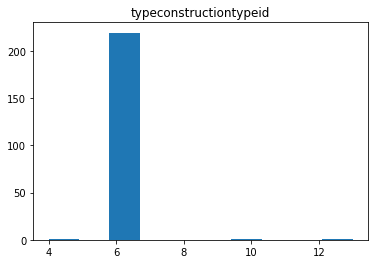

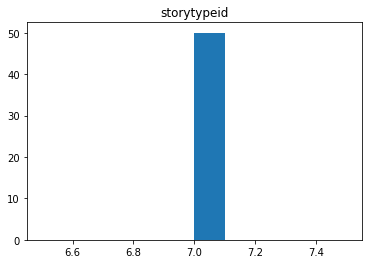

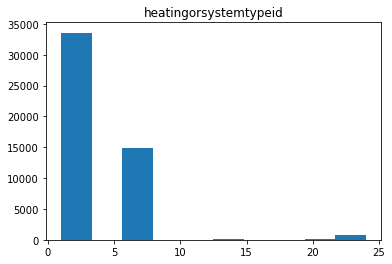

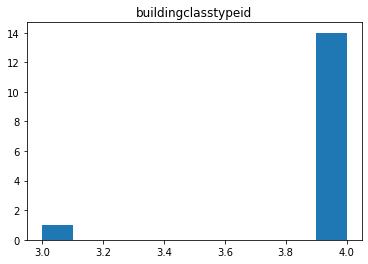

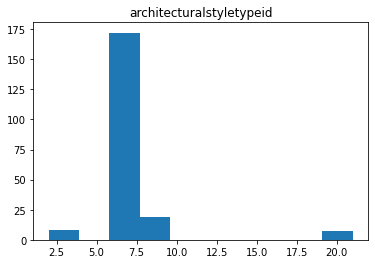

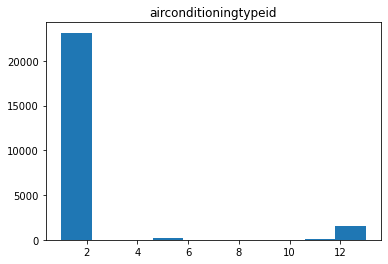

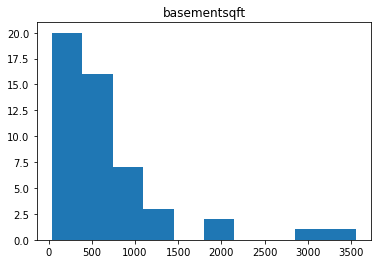

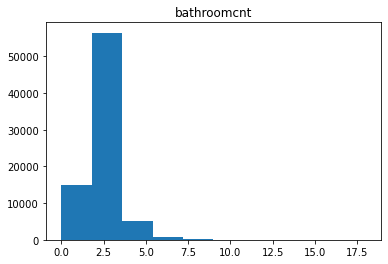

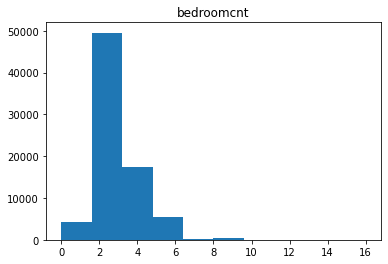

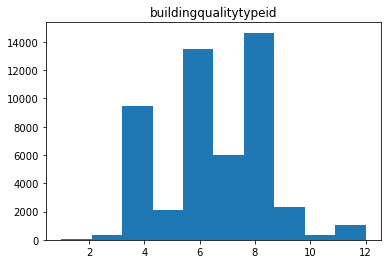

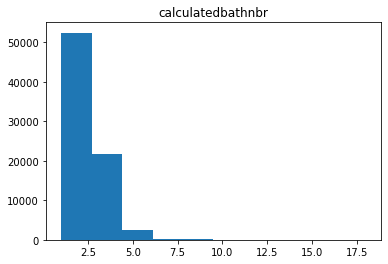

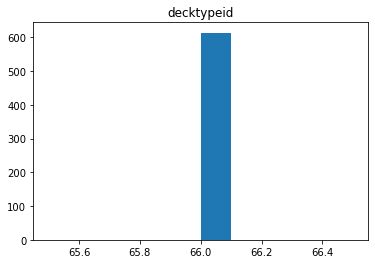

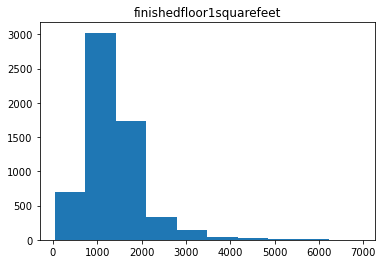

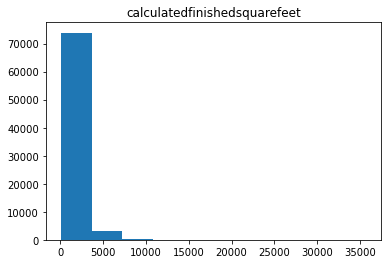

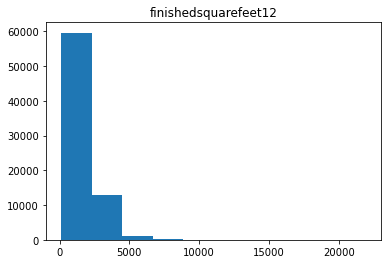

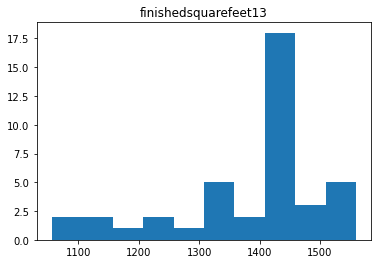

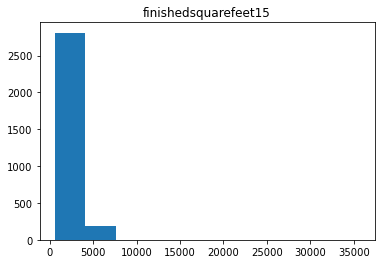

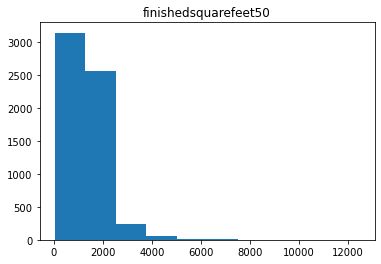

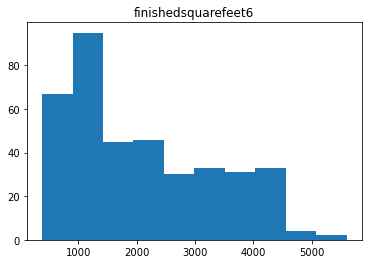

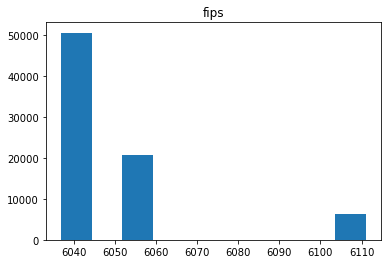

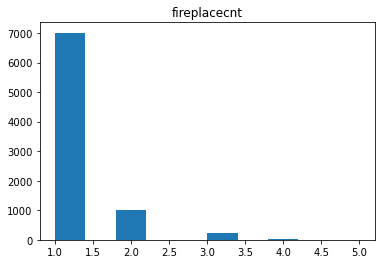

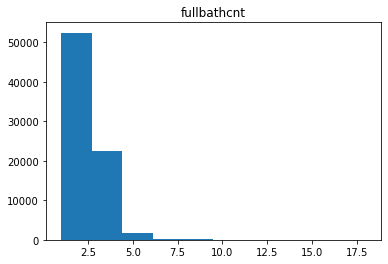

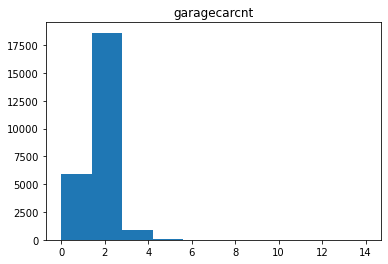

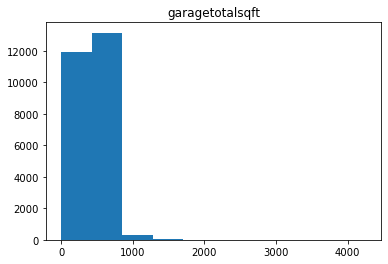

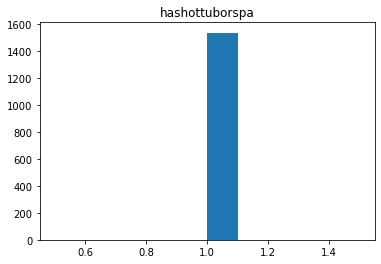

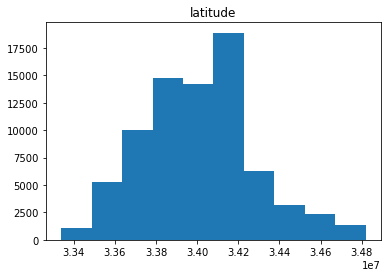

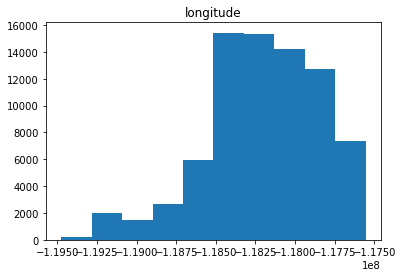

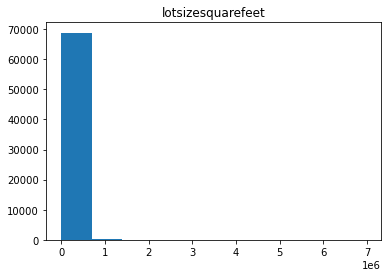

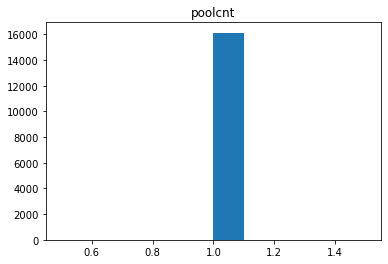

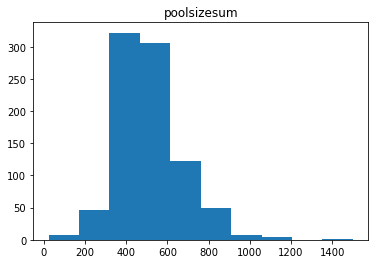

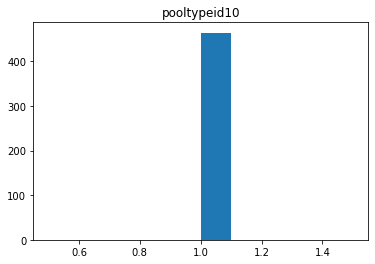

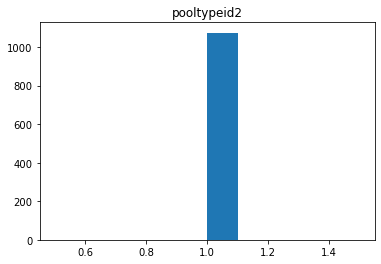

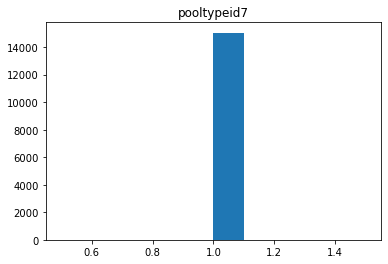

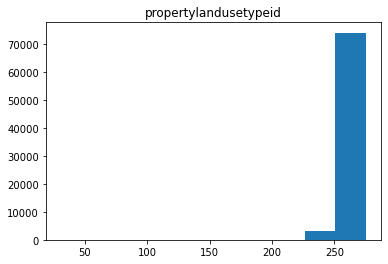

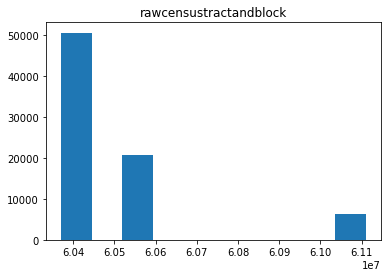

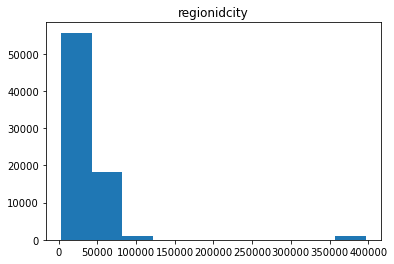

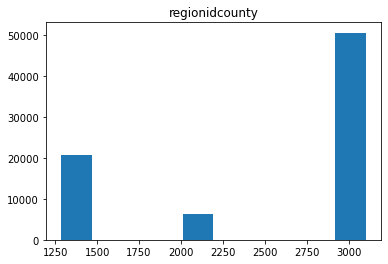

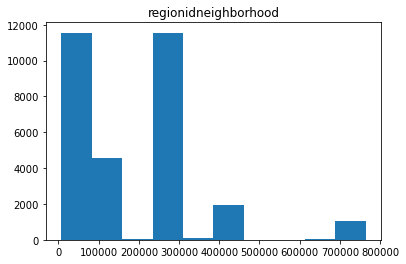

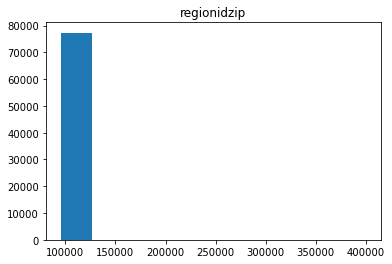

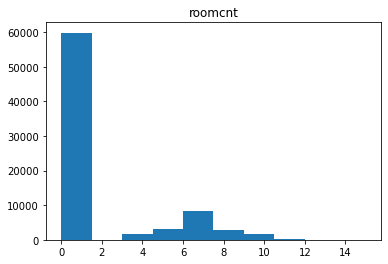

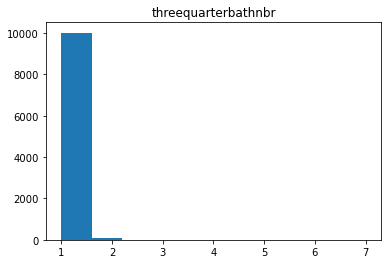

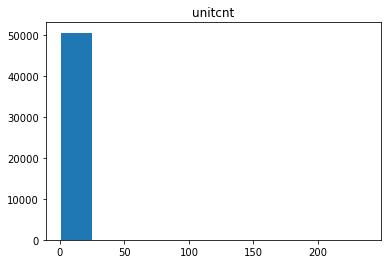

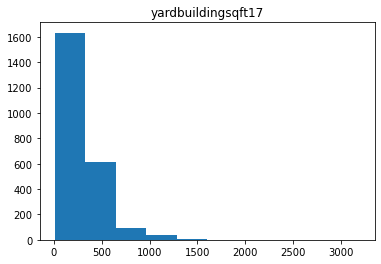

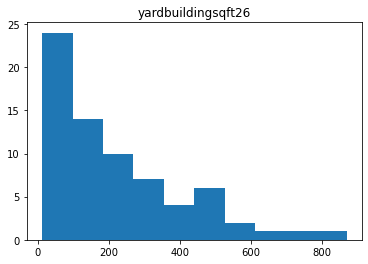

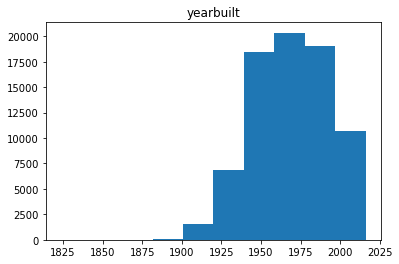

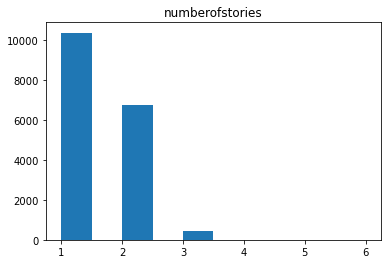

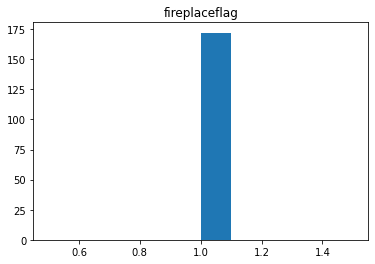

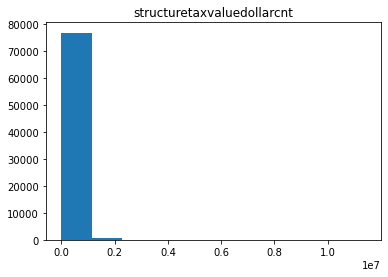

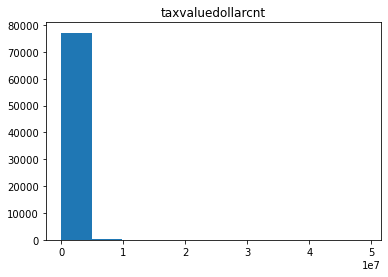

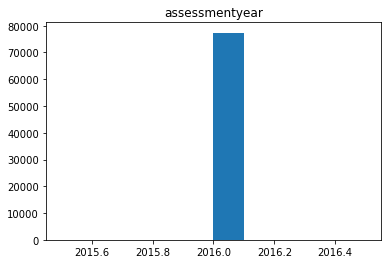

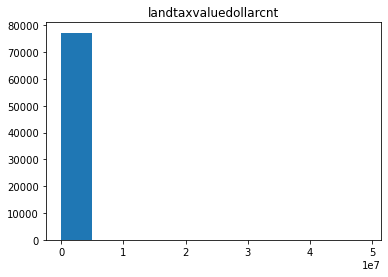

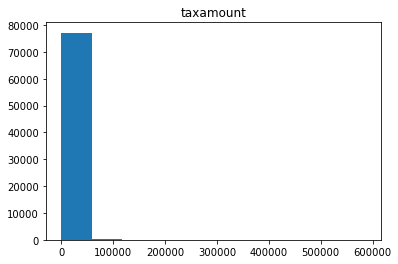

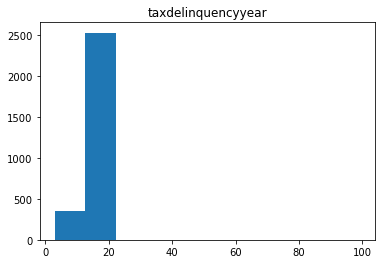

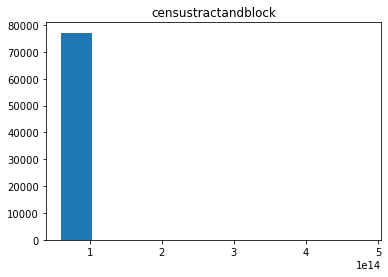

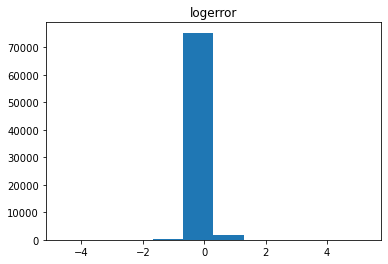

In [7]:
#distributions
for col in df.columns:
    if df[col].dtype != object and col != 'parcelid' and col != 'id':
        plt.hist(df[col])
        plt.title(col)
        plt.show()

### Findings
- many nulls in columns and rows that need to be removed and/or filled in 
- outliers are present and need to be removed
- redundant/unnecessary columns can be dropped
- columns can be renamed for better readability
- change datatypes to integers
- create dummy vars for fips
- index can be set to parcelid
- new features can be created for age, tax rate, acres, etc.

# Data Preparation

In [68]:
df = w.wrangle_zillow(cached=True)
df.head()

,heating_system_type_id,bathrooms,bedrooms,prop_sqft,fips,fireplace_cnt,latitude,longitude,lot_sqft,pool_cnt,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,2,2.0,3.0,2107.0,6037,0.0,0.342226,-1.186174,9158,1.0,...,1.227188,0.210239,0.2,0.5,118.488372,0.4,40.891461,0.3,0.666667,1
10711877,2,2.0,4.0,1882.0,6037,0.0,0.342203,-1.186164,9035,1.0,...,1.230895,0.207415,0.2,0.4,134.431456,0.4,45.047039,0.3,0.500000,1
10711888,2,2.0,4.0,1882.0,6037,0.0,0.342225,-1.186169,9800,0.0,...,1.229132,0.224977,0.2,0.4,136.870882,0.4,29.115510,0.3,0.500000,1
10711910,2,2.0,3.0,1477.0,6037,0.0,0.342219,-1.186157,11285,1.0,...,1.430790,0.259068,0.3,0.3,39.247123,0.1,1.777847,0.1,0.666667,1
10711923,2,2.0,4.0,1918.0,6037,0.0,0.342206,-1.186153,11239,1.0,...,1.261220,0.258012,0.3,0.4,87.522941,0.3,22.029540,0.3,0.500000,1


In [9]:
df.dtypes

heating_system_type_id          int64
bathrooms                     float64
bedrooms                      float64
prop_sqft                     float64
fips                            int64
fireplace_cnt                 float64
latitude                      float64
longitude                     float64
lot_sqft                        int64
pool_cnt                      float64
region_id_city                  int64
year_built                    float64
fireplace_flag                  int64
struct_tax_value              float64
tax_value                     float64
land_tax_value                float64
tax_amount                    float64
log_error                     float64
heating_system_desc            object
la_cnty                         uint8
orange_cnty                     uint8
ventura_cnty                    uint8
log_error_class              category
age                           float64
age_bin                       float64
taxrate                       float64
acres       

In [10]:
df.isnull().sum()

heating_system_type_id       0
bathrooms                    0
bedrooms                     0
prop_sqft                    0
fips                         0
fireplace_cnt                0
latitude                     0
longitude                    0
lot_sqft                     0
pool_cnt                     0
region_id_city               0
year_built                   0
fireplace_flag               0
struct_tax_value             0
tax_value                    0
land_tax_value               0
tax_amount                   0
log_error                    0
heating_system_desc          0
la_cnty                      0
orange_cnty                  0
ventura_cnty                 0
log_error_class              0
age                          0
age_bin                      2
taxrate                      0
acres                        0
acres_bin                    0
sqft_bin                     0
structure_dollar_per_sqft    0
structure_dollar_sqft_bin    1
land_dollar_per_sqft         0
lot_doll

In [69]:
#split
train_validate, test = train_test_split(df, train_size=.80, random_state=123)
train, validate = train_test_split(train_validate, random_state=123)

train.shape, validate.shape, test.shape

((36144, 35), (12048, 35), (12049, 35))

In [70]:
train.head()

,heating_system_type_id,bathrooms,bedrooms,prop_sqft,fips,fireplace_cnt,latitude,longitude,lot_sqft,pool_cnt,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
parcelid,,,,,,,,,,,,,,,,,,,,,
11894122,2,2.0,2.0,995.0,6037,0.0,0.341017,-1.181270,10436,0.0,...,1.215687,0.239578,0.2,0.1,89.447236,0.3,25.488693,0.3,1.000000,0
11464250,7,2.0,2.0,1290.0,6037,0.0,0.339541,-1.184421,6617,1.0,...,1.340890,0.151905,0.2,0.3,132.060465,0.4,102.982469,0.5,1.000000,1
13041379,2,2.0,5.0,2156.0,6037,0.0,0.341239,-1.178268,7509,0.0,...,1.247128,0.172383,0.2,0.5,88.437384,0.3,14.135970,0.2,0.400000,0
13939598,2,4.0,3.0,2856.0,6059,0.0,0.337766,-1.178187,18200,0.0,...,1.043118,0.417815,0.3,0.6,56.804272,0.2,1.765934,0.1,1.333333,0
11123078,2,3.0,4.0,2040.0,6037,0.0,0.344540,-1.184890,10419,1.0,...,1.406188,0.239187,0.2,0.5,149.644608,0.4,25.363950,0.3,0.750000,0


In [71]:
#choosing features to explore on
X = train[['bathrooms', 'bedrooms', 'prop_sqft', 'fips', 'tax_value', 'log_error', 'la_cnty', 'orange_cnty', 'ventura_cnty']]
X.head()

,bathrooms,bedrooms,prop_sqft,fips,tax_value,log_error,la_cnty,orange_cnty,ventura_cnty
parcelid,,,,,,,,,
11894122,2.0,2.0,995.0,6037,355000.0,-0.016118,1,0,0
11464250,2.0,2.0,1290.0,6037,851793.0,-0.048644,1,0,0
13041379,2.0,5.0,2156.0,6037,296818.0,0.011101,1,0,0
13939598,4.0,3.0,2856.0,6059,194373.0,0.060658,0,1,0
11123078,3.0,4.0,2040.0,6037,569542.0,-0.021626,1,0,0


Data is:
- cleaned/prepped 
- split into train, validate, test for exploration.
- ready to be explored on training (in-sample) data.

# Data exploration

#### Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?


In [14]:
#create a df to show the name of the county for each fips code
county = pd.DataFrame({'fips': [6037, 6059, 6111],
                       'County': ['Los Angeles', 'Orange', 'Ventura']})
county.head()

,fips,County
0,6037,Los Angeles
1,6059,Orange
2,6111,Ventura


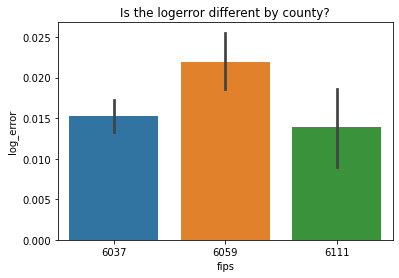

In [15]:
sns.barplot(data = train, x = 'fips', y = 'log_error')
plt.title("Is the logerror different by county?")
plt.show()

In [16]:
#T-test: logerror and counties
null_hypothesis = "there is no difference in logerror between counties."
alternative_hypothesis = "there is a difference in logerror between counties."
confidence_level = .95
alpha = 1 - confidence_level

la_county = train[train.fips  == 6037].log_error
other_counties = train[train.fips != 6037].log_error

t, p = stats.ttest_ind(la_county, other_counties)

print("t:", t, "p:", p)
if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)

else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

t: -2.7081101688593856 p: 0.006769939044008215
We reject the null hypothesis.
We can move forward with the alternative hypothesis: there is a difference in logerror between counties.


### Takeaways
- logerror is highest in Orange county
- logerror is roughly the same in Los Angeles and Ventura (slightly less in Ventura).
- T-test resulted in rejecting the null hypothesis meaning we can assume that there is a difference in logerror between counties
- Results show logerror is significantly different for properties in LA County vs Orange County vs Ventura County

#### Is there a correlation between square footage of a home and log error?

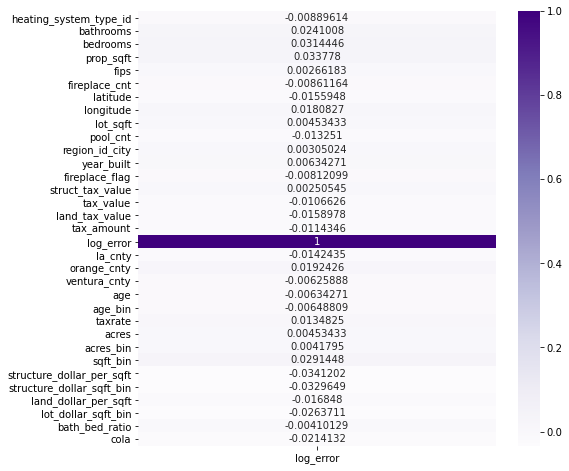

In [17]:
plt.figure(figsize = (8,8))

corrMatrix = train.corr()

htmp = pd.DataFrame(corrMatrix['log_error'],
              index=corrMatrix.index)

sns.heatmap(htmp, annot=True, fmt="g", cmap='Purples')

plt.show()

### Takeaways
- logerror doesn't have much correlation with anything
- however, logerror shows more correlation with prop_sqft than the rest of the features

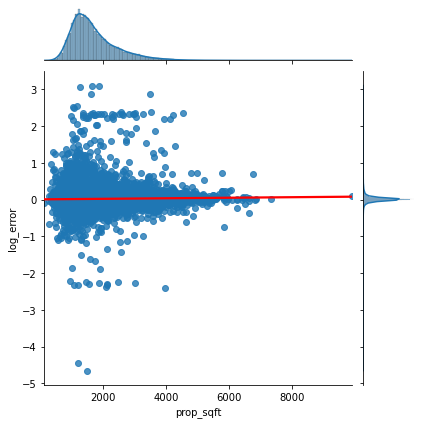

In [18]:
g = sns.jointplot(x="prop_sqft", y="log_error", data=train, kind='reg')
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)

### Takeaways
- slight upward trend in log error as square feet increases
- homes between 1,000-4,000 sq ft have quite a bit of variance in log error

In [19]:
#Correlation Test: logerror and square feet
null_hypothesis = "there is no correlation between logerror and square footage of a home."
alternative_hypothesis = "there is a correlation between logerror and square footage of a home."
confidence_level = .95
alpha = 1 - confidence_level

#Use pearsonr function
corr, p = stats.pearsonr(train.log_error, train.prop_sqft)

print("corr:", corr, "p:", p)

if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

corr: 0.033777978278789964 p: 1.333193135962451e-10
We reject the null hypothesis.
We can move forward with the alternative hypothesis: there is a correlation between logerror and square footage of a home.


### Takeaways
- Pearson's correlation test resulted in rejecting the null hypothesis, so we can assume that there is a correlation between logerror and square footage of a home
- Results show a correlation between square footage of a home and logerror

#### Could square footage and county location help predict log error?

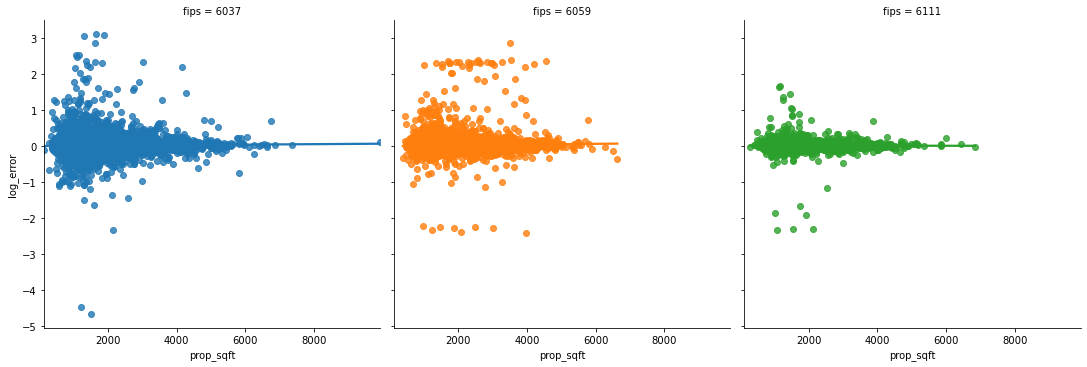

In [20]:
sns.lmplot(data=train, 
           x='prop_sqft', 
           y='log_error', 
           hue = 'fips', 
           col = 'fips', 
           col_wrap=3)

plt.show()

### Takeaways
- logerror shows the highest amount of variance for LA and Orange county.
- least amount of variance in Ventura county

#### Is there a relationship between tax value and log error?

<AxesSubplot:xlabel='tax_value', ylabel='log_error'>

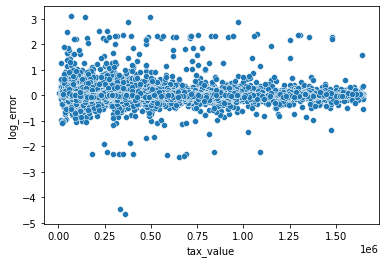

In [21]:
sns.scatterplot(x = 'tax_value', y = 'log_error', data = train)

In [22]:
sns.scatterplot(data=train[train.la_cnty == 1], y=continuous_target, x='tax_value')
plt.title('LA')
plt.show()
sns.scatterplot(data=train[train.orange_cnty == 1], y=continuous_target, x='tax_value')
plt.title("Orange County")
plt.show()
sns.scatterplot(data=train[train.ventura_cnty == 1], y=continuous_target, x='tax_value')
plt.title('Ventura County')
plt.show()

NameError: name 'continuous_target' is not defined

In [23]:
#Correlation Test: tax value and logerror
null_hypothesis = "there is no correlation between tax value and logerror."
alternative_hypothesis = "there is a correlation between tax value and logerror."
confidence_level = .95
alpha = 1 - confidence_level

#Use pearsonr function
corr, p = stats.pearsonr(train.tax_value, train.log_error)

print("corr:", corr, "p:", p)
if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

corr: -0.010662561605037871 p: 0.042651322674711264
We reject the null hypothesis.
We can move forward with the alternative hypothesis: there is a correlation between tax value and logerror.


# Data Modeling and Evaluation

### Clustering for age and tax value

In [24]:
#start w/ 2 features
X = train[['age', 'tax_value']]
X.head()

,age,tax_value
parcelid,,
11894122,30.0,355000.0
11464250,72.0,851793.0
13041379,66.0,296818.0
13939598,61.0,194373.0
11123078,24.0,569542.0


In [25]:
#scale data
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
X_scaled.head()

,age,tax_value
11894122,-1.028436,-0.218550
11464250,0.772490,1.435030
13041379,0.515215,-0.412210
13939598,0.300819,-0.753199
11123078,-1.285712,0.495555


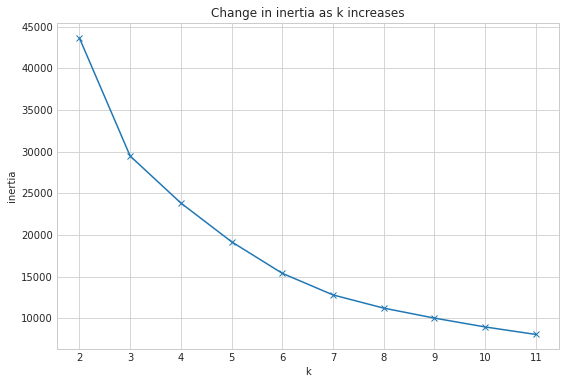

In [28]:
#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

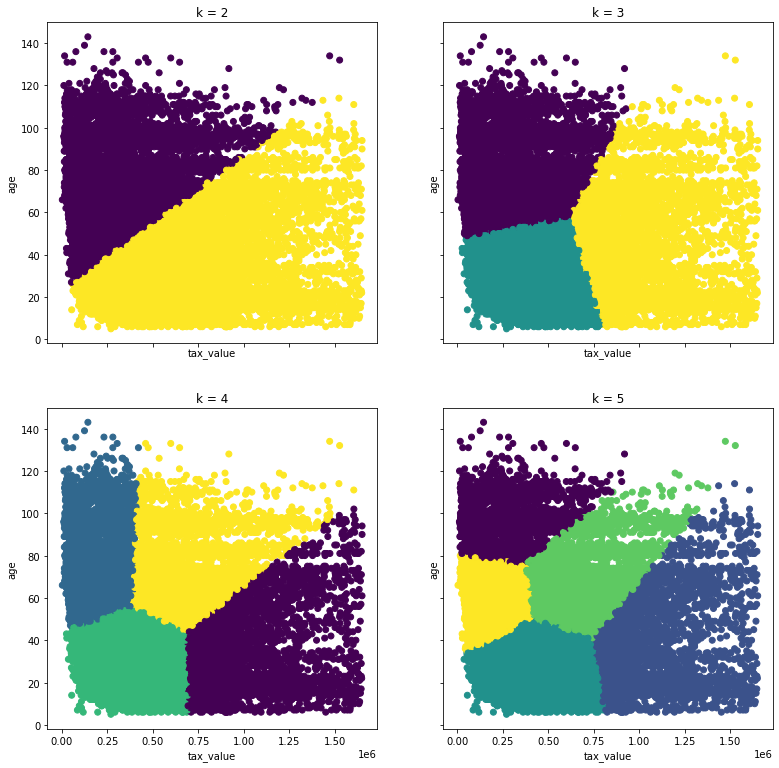

In [31]:
# What value of k is appropriate?

fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(X.tax_value, X.age, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='tax_value', ylabel='age')

### Clustering for bath/bed ratio and prop sq ft

In [33]:
#start w/ 2 features
X = train[['bath_bed_ratio', 'prop_sqft']]
X.head()

,bath_bed_ratio,prop_sqft
parcelid,,
11894122,1.000000,995.0
11464250,1.000000,1290.0
13041379,0.400000,2156.0
13939598,1.333333,2856.0
11123078,0.750000,2040.0


In [34]:
#scale data
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
X_scaled.head()

,bath_bed_ratio,prop_sqft
11894122,0.966006,-0.968097
11464250,0.966006,-0.574821
13041379,-1.277330,0.579676
13939598,2.212303,1.512873
11123078,0.031282,0.425032


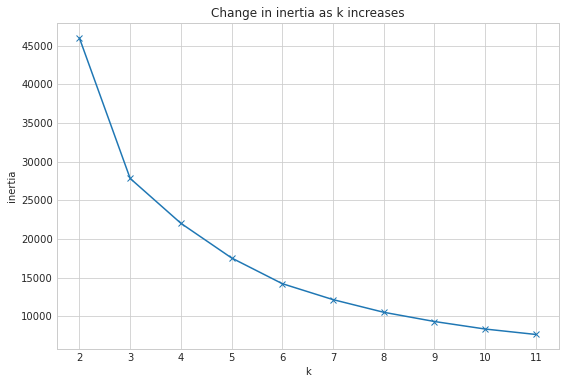

In [35]:
#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

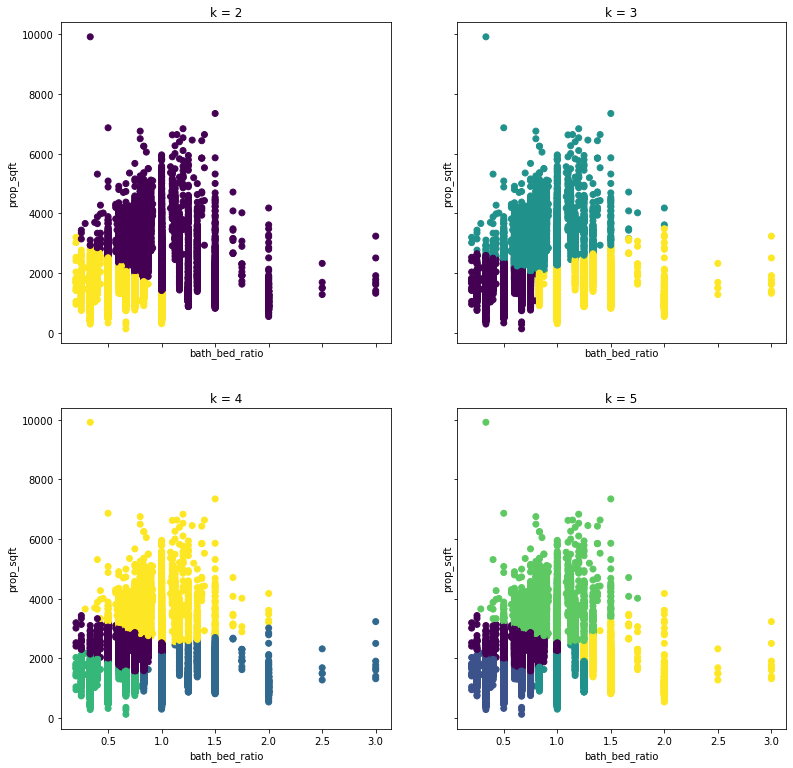

In [36]:
# What value of k is appropriate?

fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(X.bath_bed_ratio, X.prop_sqft, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='bath_bed_ratio', ylabel='prop_sqft')

### Clustering for county and prop sq ft

In [37]:
#start w/ 2 features
X = train[['fips', 'prop_sqft']]
X.head()

,fips,prop_sqft
parcelid,,
11894122,6037,995.0
11464250,6037,1290.0
13041379,6037,2156.0
13939598,6059,2856.0
11123078,6037,2040.0


In [38]:
#scale data
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
X_scaled.head()

,fips,prop_sqft
11894122,-0.611477,-0.968097
11464250,-0.611477,-0.574821
13041379,-0.611477,0.579676
13939598,0.399331,1.512873
11123078,-0.611477,0.425032


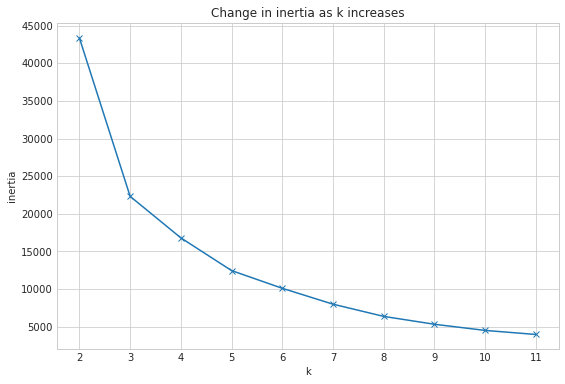

In [39]:
#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

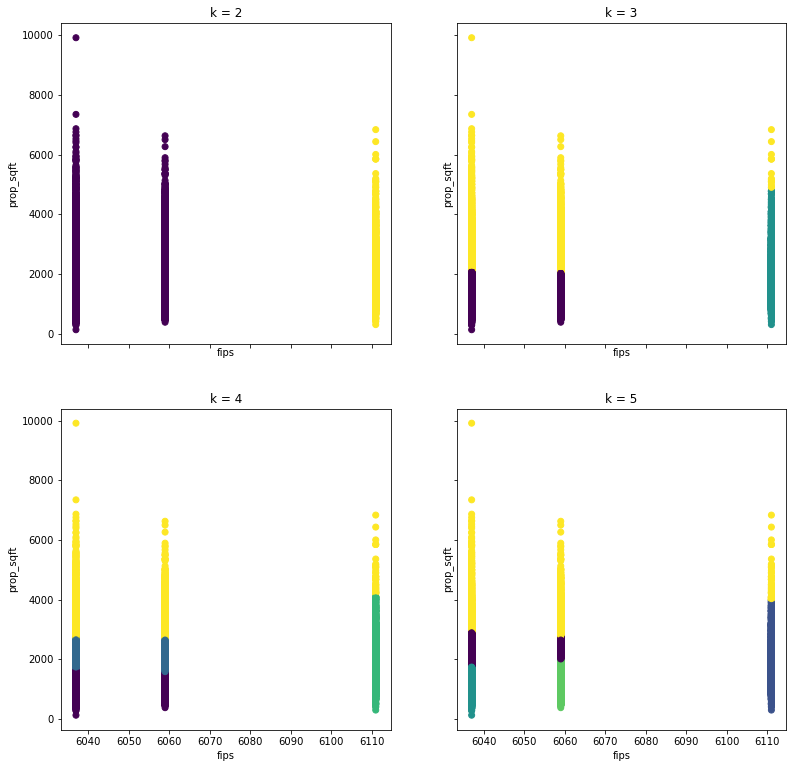

In [40]:
# What value of k is appropriate?

fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(X.fips, X.prop_sqft, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='fips', ylabel='prop_sqft')

### Clustering for age and prop sq ft

In [42]:
#start w/ 2 features
X = train[['age', 'prop_sqft']]
X.head()

,age,prop_sqft
parcelid,,
11894122,30.0,995.0
11464250,72.0,1290.0
13041379,66.0,2156.0
13939598,61.0,2856.0
11123078,24.0,2040.0


In [43]:
#scale data
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
X_scaled.head()

,age,prop_sqft
11894122,-1.028436,-0.968097
11464250,0.772490,-0.574821
13041379,0.515215,0.579676
13939598,0.300819,1.512873
11123078,-1.285712,0.425032


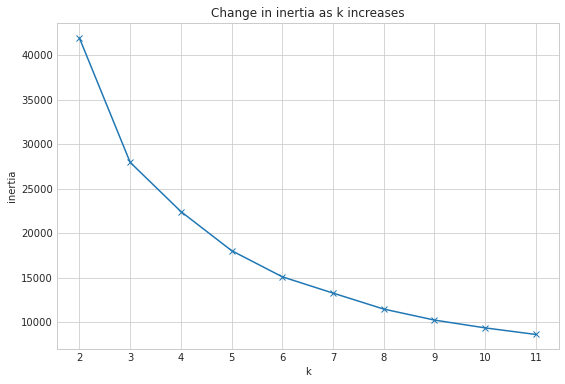

In [46]:
#plot inertia vs k to choose k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

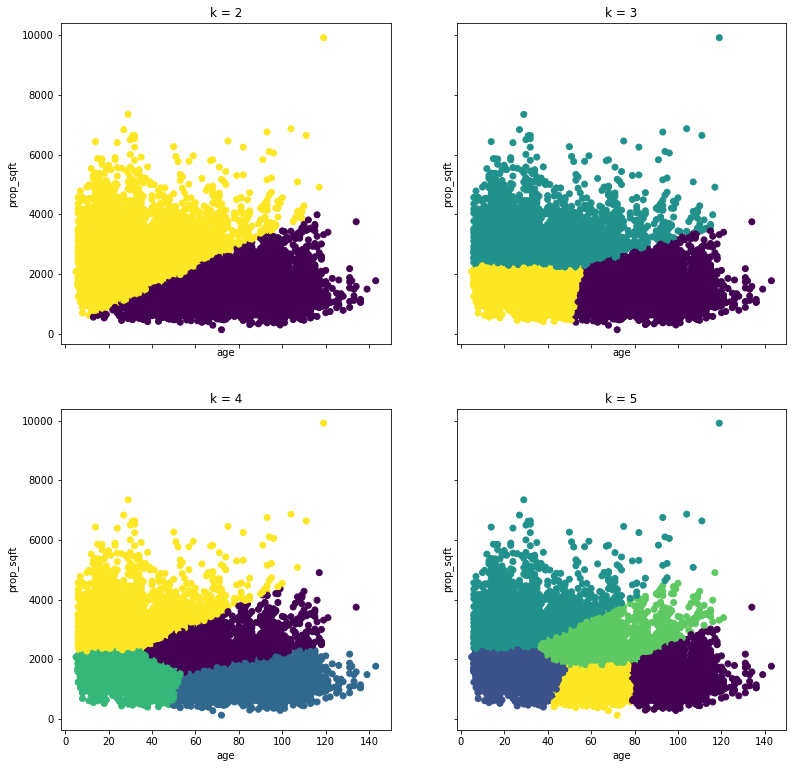

In [44]:
# age and square feet

fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(X.age, X.prop_sqft, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='age', ylabel='prop_sqft')

In [47]:
# Make the kmeans object
kmeans = KMeans(n_clusters=4)

# fit the kmeans model
kmeans.fit(X)

# use the thing
kmeans.predict(X)

array([0, 0, 1, ..., 1, 3, 3], dtype=int32)

In [48]:
X["cluster"] = kmeans.predict(X)
X.head()

,age,prop_sqft,cluster
parcelid,,,
11894122,30.0,995.0,0
11464250,72.0,1290.0,0
13041379,66.0,2156.0,1
13939598,61.0,2856.0,1
11123078,24.0,2040.0,3


In [50]:
cluster0 = X[X.cluster == 0]
cluster1 = X[X.cluster == 1]
cluster2 = X[X.cluster == 2]
cluster3 = X[X.cluster == 3]

In [61]:
X.groupby("cluster").describe().T

cluster                     0            1            2             3
age       count  14786.000000  6354.000000  1879.000000  13125.000000
          mean      61.455972    44.598048    36.524747     52.611200
          std       21.890310    22.191635    23.878337     22.067729
          min        6.000000     6.000000     6.000000      5.000000
          25%       45.000000    26.000000    19.000000     36.000000
          50%       65.000000    44.000000    29.000000     55.000000
          75%       73.000000    58.000000    49.000000     67.000000
          max      136.000000   131.000000   134.000000    143.000000
prop_sqft count  14786.000000  6354.000000  1879.000000  13125.000000
          mean    1108.556608  2546.040447  3792.281001   1715.499962
          std      206.108458   287.988937   619.471322    200.666106
          min      128.000000  2130.000000  3166.000000   1412.000000
          25%      977.000000  2298.000000  3358.000000   1541.000000
          50%     1140.000000  2499.000000  3617.000000   1687.000000
          75%     1272.000000  2764.750000  4035.000000   1875.000000
          max     1412.000000  3166.000000  9918.000000   2129.000000

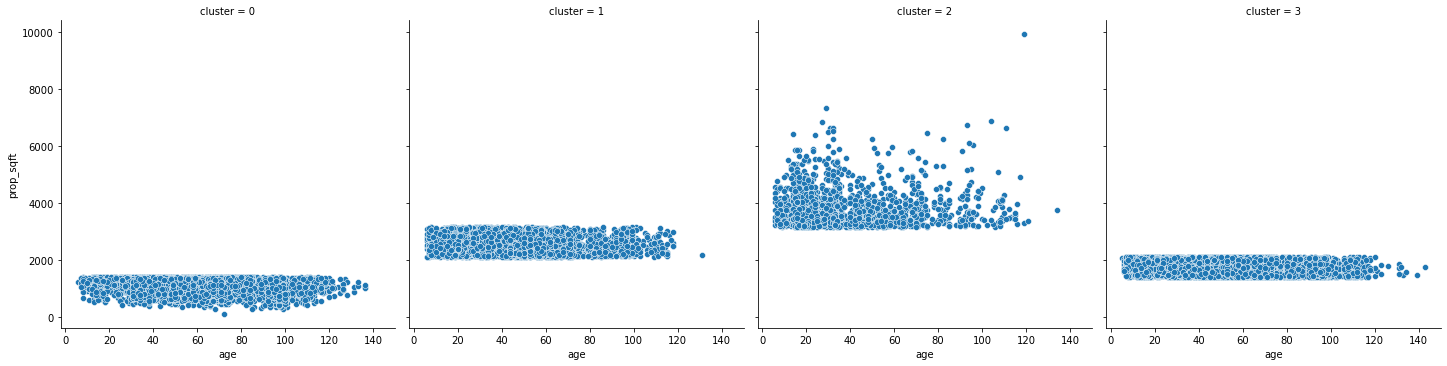

In [62]:
sns.relplot(x="age", y="prop_sqft", col="cluster", data=X)


In [72]:
# Useful functions for clustering:


def create_cluster(train, X, k):
    # takes in train, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return train (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and unscaled centroids as a dataframe
    scaler = StandardScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 539)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    train['cluster'] = kmeans.predict(X_scaled)
    train['cluster'] = 'cluster_' + train.cluster.astype(str)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    return train, X_scaled, scaler, kmeans, centroids


def create_scatter_plot(x,y,train,kmeans, X_scaled, scaler):
    # takes in x and y (variable names as strings, along with returned objects from previous
    # fuction create_cluster and creates a plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = train, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')

In [93]:
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 4)


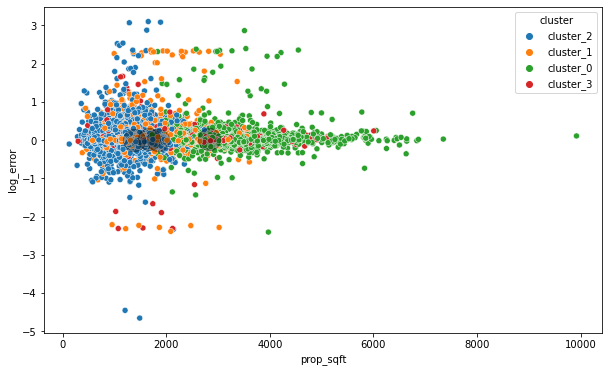

In [94]:
create_scatter_plot('prop_sqft','log_error',train,kmeans, X_scaled, scaler)

In [101]:
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 3)


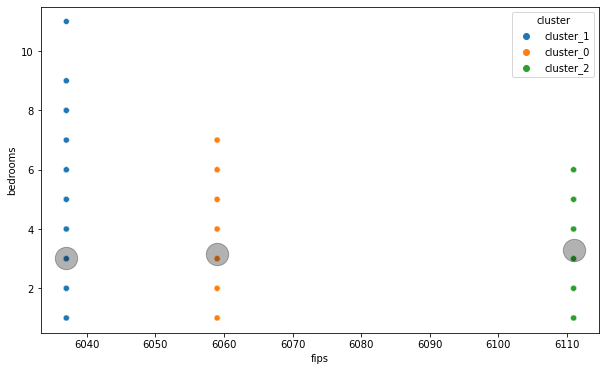

In [102]:
create_scatter_plot('fips','bedrooms',train,kmeans, X_scaled, scaler)

In [103]:
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 3)


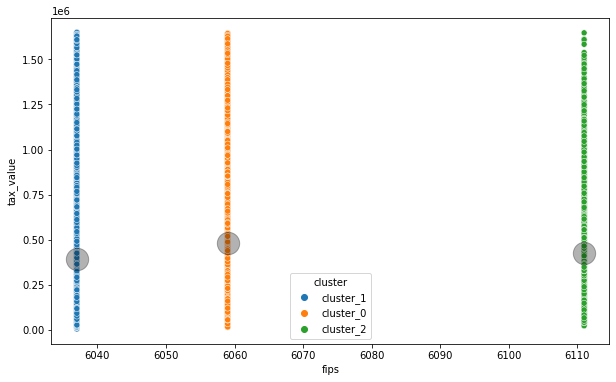

In [106]:
create_scatter_plot('fips','tax_value',train,kmeans, X_scaled, scaler)

In [109]:
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 2)


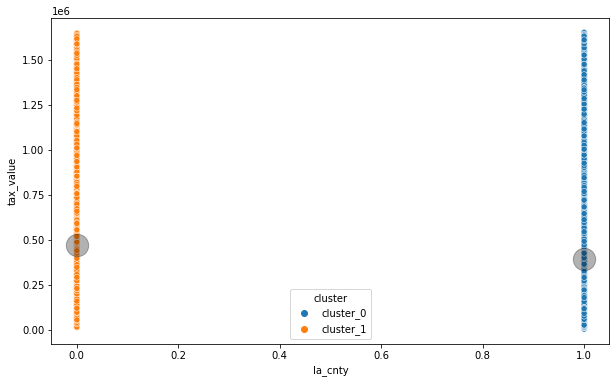

In [111]:
create_scatter_plot('la_cnty','tax_value',train,kmeans, X_scaled, scaler)

In [117]:
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 3)


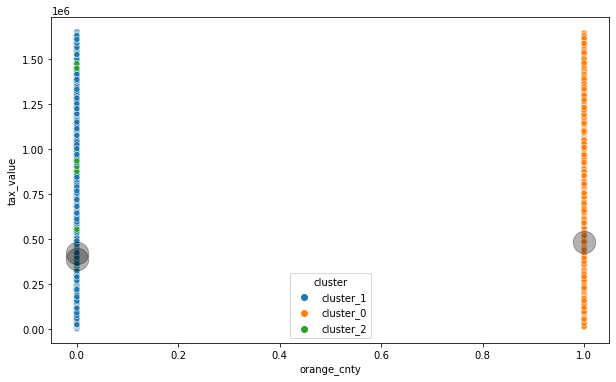

In [118]:
create_scatter_plot('orange_cnty','tax_value',train,kmeans, X_scaled, scaler)

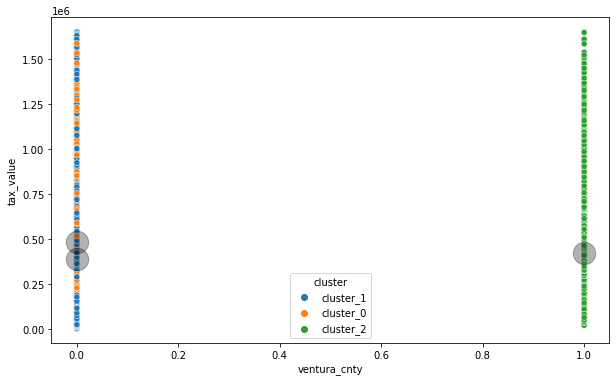

In [119]:
create_scatter_plot('ventura_cnty','tax_value',train,kmeans, X_scaled, scaler)

KeyError: 'age'

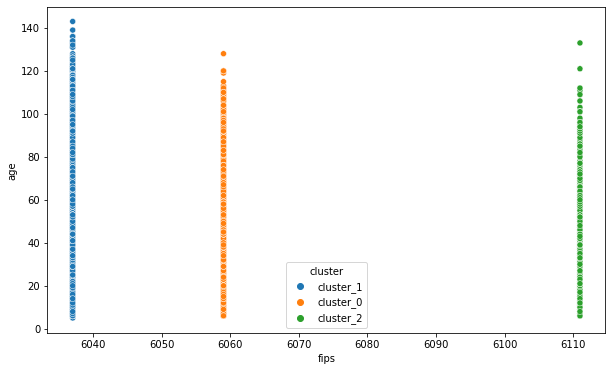

In [122]:
create_scatter_plot('fips','age',train,kmeans, X_scaled, scaler)

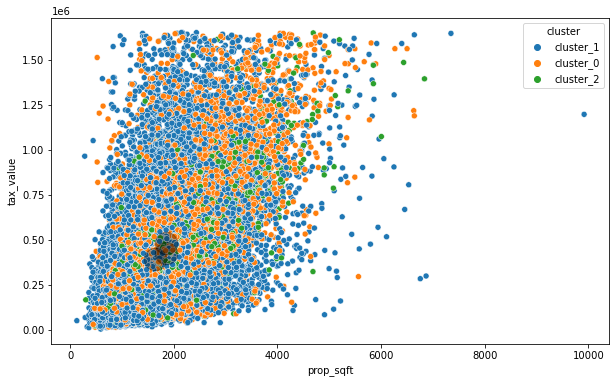

In [139]:
create_scatter_plot('fips','age',train,kmeans, X_scaled, scaler)

# Don't know what to takeaway, don't know what to model, don't understand clustering too much

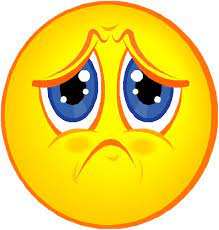

In [ ]:
#set up X inputs and y target variable for each split for modeling
X_train = train.drop(columns=['log_error'])
y_train = train.log_error

X_validate = validate.drop(columns=['log_error'])
y_validate = validate.log_error

X_test = test.drop(columns=['log_error'])
y_test = test.log_error